In [1]:
# Autograding imports - do not modify this cell
import matplotcheck.notebook as nb
import matplotcheck.autograde as ag
import matplotcheck.raster as rs

In [2]:
# YOUR CODE HERE
import warnings
import os
from glob import glob
import re  # regular expressions
import numpy as np
import numpy.ma as ma
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap
import matplotlib as mpl
import geopandas as gpd
import rasterio as rio
from rasterio.plot import plotting_extent
import earthpy as et
import earthpy.spatial as es
import earthpy.plot as ep
import earthpy.mask as em
from shapely.geometry import box
warnings.simplefilter('ignore')

# Adjust plot parameters throughout notebook 
mpl.rcParams['figure.figsize'] = (14, 14)
mpl.rcParams['axes.titlesize'] = 20

# Set working directory to 'earth-analytics' and data folder.
os.chdir(os.path.join(et.io.HOME, 'earth-analytics'))

In [3]:
# Add your function here. Do NOT modify the function name
def crop_stack_data(files_to_crop, crop_dir_path, crop_bound):
    """Crops a set of tif files and saves them 
    in a crop directory. Returns a stacked numpy 
    array of bands.
    
    Parameters
    ----------
    files_to_crop : list
        List of paths to multispectrum scenes 
        (.tiff) to be cropped.
    
    crop_dir_path : string
        The path to an output directory.  
        use conditional statment to create one,
        if not in existance. 
        The directory will store, 
        cropped and stacked bands.
        
    crop_bound : gpd (GeoPandas GeoDataFrame)
        Vector shape file geodataframe used for 
        cropping area of interest from the files_to_crop.
    
    Returns
    -------
    all_bands_stack : numpy array(s)
        Stacked and cropped numpy array bands 
        (our new aoi's).
    
    fire_crop_bound : GeoPandas GeoDataFrame
        A vector shape file that either shares 
        the crs of the stacked bands or is 
        reprojected from the crop_bound crs.
    """
    if not os.path.exists(crop_dir_path):
        os.mkdir(crop_dir_path)
        
    # Reproject boundary .shp to geotiff crs 
    with rio.open(files_to_crop[0]) as landsat_src:
        if not crop_bound.crs == landsat_src.crs:
            fire_crop_bound = crop_bound.to_crs(
                                  landsat_src.crs)
            extent = plotting_extent(landsat_src)
#         crop_bound = crop_bound.to_crs(src.crs)
 
    #  crop images using earthpy 
    es.crop_all(raster_paths=files_to_crop,
                output_dir=crop_dir_path,
                geoms= fire_crop_bound,
                overwrite=True)
    
    # Retrieve cropped bands from the new directory
    all_bands = sorted(glob(os.path.join(
                       crop_dir_path, "*.tif")))
    # Stack cropped bands
    all_stack_bands, stack_bands_meta = es.stack(all_bands)
    
    # return cropped, stacked bands and fire boundary
    return all_stack_bands, stack_bands_meta, fire_crop_bound

In [4]:
# Add your function here. Do NOT modify the function name
def mask_data(arr, path_to_qa):   
    """Function that masks numpy arrays 
    using qa layer.
    
    Parameters
    ----------
    arr : numpy array
        Numpy array(s) of bands of aoi       
    
    path_to_qa : str
        Path to QA layer(s) associated with each band        
    
    Returns
    -------
    arr : masked numpy array
        Updated numpy array(s) of bands with high cloud
        confidence, clouds and cloud shadows masked.        
    """
    # 1. open the qa layer
    with rio.open(path_to_qa[0]) as src:
        mask_arr = src.read(1)
        
    # Cloud mask values
    high_cloud_confidence = em.pixel_flags["pixel_qa"]["L8"]["High Cloud Confidence"]
    cloud = em.pixel_flags["pixel_qa"]["L8"]["Cloud"]
    cloud_shadow = em.pixel_flags["pixel_qa"]["L8"]["Cloud Shadow"]

    all_masked_values = cloud_shadow + cloud + high_cloud_confidence
    
    # 2. Mask the numpy array 
    if any(i in np.unique(mask_arr) for i in all_masked_values):
        landsat_masked_bands = em.mask_pixels(arr,
                                              mask_arr,
                                              vals=all_masked_values)
        return landsat_masked_bands
    else:
        print("There are no pixels to mask")
        return arr

In [5]:
# Define function to plot site NDVI both with and without QA
def plot_NDVI_NBR(dynamic_site, dyanmic_bound, title):
    """
    Plots  ndvi and nbr per site per satellite pass using
    two dictionaries.
    Function includes ability to plot any file as csv containing
    four columns named as below:
    columns:   site, date,  ndvi, nbr.

    Parameters
    ----------
    fdir : str, path
        Object of directory path or actual file path
        to a directory containing .csv files.
        e.g. fdir = glob(os.path.join(path))

    fname: str
        String of .csv file name.

    na_string: str
        The string associated with the NA data in the dataset,
        e.g. na, NaN, None, --, etc.

    title: str
        Object of title or actual title describing plot.

    Returns
    ------
    plot :
        Printed plot with legend.
    """
    # Import .csv as pd.Dataframe for plotting
    df = pd.read_csv(os.path.join(fdir, fname), parse_dates=[
                     'date'], index_col=['date'], na_values=na_str)

    # Drop NAs
    df = df[['site', 'date', 'ndvi', 'nbr']].dropna()

    # Parse mean_ndvi by site
    groups = df.groupby('site')

    # Plot
    fig, ax = plt.subplots(figsize=(10, 8))
    plt.suptitle(title, fontsize=16, y=1.0, ha='center')

    for sites, group in groups:
        ax.plot(group.index.values,
                group['mean_ndvi'].values, 
                ls='-', marker='o', 
                label=sites)

    # Define the date format
    date_form_b = DateFormatter("%b")
    ax.xaxis.set_major_formatter(date_form_b)

    # Define axes and legend
    plt.xlabel("Month", fontsize=15)
    plt.ylabel("Mean NDVI", fontsize=15)
    ax.legend()

In [6]:
# Add your function here. Do NOT modify the function name
def classify_dnbr(arr):
    """Function that creates a new numpy array of classified
    values using difference normalized burn ratio (dNBR) as
    numpy array. 
    
    Parameters
    ----------
    arr : Numpy array
        Numpy array(s) containing dNBR data.        
    
    Returns
    -------
    arr_class : Numpy array
        Numpy array(s) containing reclassified 
        dNBR values in 5 possible classes.        
    """

    # YOUR CODE HERE
    # bins to define fire severity
    class_bins = [-np.inf, -.1, .1, .27, .66, np.inf]
    
    # code to classify dnbr values 
    arr_reclass = np.digitize(arr, class_bins)
        
    return arr_reclass

In [7]:
# Set working directory using conditional statement
workdir_path = (os.path.join(et.io.HOME, "earth-analytics"))

if os.path.exists(workdir_path):
    os.chdir(workdir_path)
else:
    print("Path does not exist yet, but making it now!")
    os.mkdir(workdir_path)
    os.chdir(workdir_path)

# Check working directory
os.getcwd()

'C:\\Users\\bina_\\earth-analytics'

In [8]:
# all_sites contain path to both sites 
base_path = os.path.join("data","sd_fires_2014", "sites")

# Define list of directories in "sites"
all_sites = glob(os.path.join(base_path, "*/"))
all_sites.sort()
all_sites

['data\\sd_fires_2014\\sites\\BERNARDO\\',
 'data\\sd_fires_2014\\sites\\COCOS\\',
 'data\\sd_fires_2014\\sites\\POINSETTIA\\',
 'data\\sd_fires_2014\\sites\\PULGAS\\',
 'data\\sd_fires_2014\\sites\\TOMAHAWK\\']

In [9]:
# Import SJER shape file and visualize it using geopandas.
base_path = os.path.join("data","sd_fires_2014", "sites")
boundary_path = os.path.join(base_path,
                                "BERNARDO", "vector",
                              "bernardo2014.shp")

# Open a shapefile using geopandas and change CRS.
bernardo_bounds = gpd.read_file(boundary_path)
# sjer_boundary= sjer_bounds.to_crs(epsg=32611)
print(bernardo_bounds.total_bounds)
print(bernardo_bounds.shape)
print(bernardo_bounds.crs)
os.getcwd()

[ 262840.9626 -554981.9991  269077.025  -551039.4485]
(1, 2)
{'init': 'epsg:3310'}


'C:\\Users\\bina_\\earth-analytics'

In [10]:

###############
# path2= os.path.join
boundary_path2 = os.path.join("data","output_sd_fires",
                              "tomahawk2014",
                              "tomahawk2014.shp")
boundary_path2

tomahawk_bounds = gpd.read_file(boundary_path2)
print("tomahawk_fire_boundary:", tomahawk_bounds.total_bounds)
print(tomahawk_bounds.shape)
print(tomahawk_bounds.crs)

tomahawk_fire_boundary: [ 249659.5826 -516958.739   256064.7452 -510592.1687]
(1, 2)
{'init': 'epsg:3310'}


In [11]:

# ###############
# # path2= os.path.join
# boundary_path2 = os.path.join(et.io.HOME, 'data','output_sd_fires'
#                               "tomahawk2014",
#                               "tomahawk.shp")
# boundary_path2

# tomahawk_bounds = gpd.read_file(boundary_path2)
# print("tomahawk_fire_bdy:", tomahawk_bounds.total_bounds)
# print(tomahawk_bounds.shape)
# print(tomahawk_bounds.crs)

##################
base_path = os.path.join("data","sd_fires_2014", "sites")
# # Define path for Colorado Springs pre-fire data
tomahawk_path = os.path.join(base_path,  "TOMAHAWK",
                    "landsat-crop", "landsat20140525",
                             "LC08_L1TP_040037_20140525_20170306_01_T1_pixel_qa.tif")
                             #"LC08_L1TP_040037_20140525_20170306_01_T1_pixel_qa.tif")
                             #"LC08_L1TP_040037_20140509_20170307_01_T1_pixel_qa.tif")

with rio.open(tomahawk_path) as tomahawk_src:
    tomahawk_csf = tomahawk_src.read()
#     clip_extent= [box(*naip_2015_src.bounds)]
    tomahawk_csf_meta = tomahawk_src.meta
    extent = plotting_extent(tomahawk_src)
    tomahawk_boundary= tomahawk_bounds.to_crs(tomahawk_src.crs)

# View and metadata shape 
print(tomahawk_csf_meta)
print(tomahawk_csf.shape)
print(tomahawk_boundary.crs)


# View data attributes and CRS.


{'driver': 'GTiff', 'dtype': 'uint16', 'nodata': 1.0, 'width': 7691, 'height': 7821, 'count': 1, 'crs': CRS.from_epsg(32611), 'transform': Affine(30.0, 0.0, 370785.0,
       0.0, -30.0, 3787815.0)}
(1, 7821, 7691)
EPSG:32611


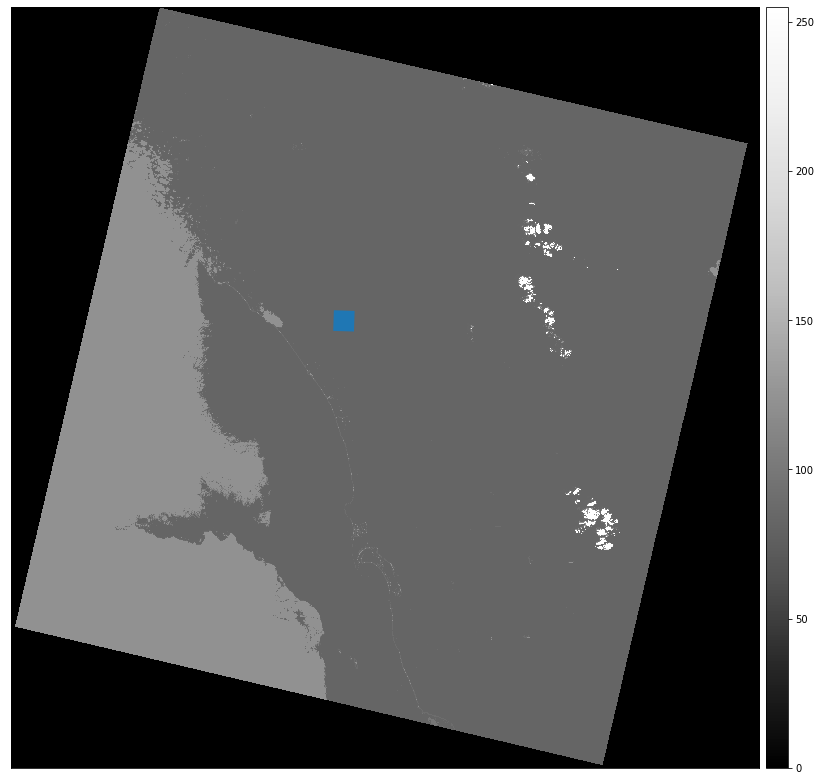

In [12]:
fig, ax = plt.subplots()
ep.plot_bands(tomahawk_csf[0], ax= ax, extent = extent)
tomahawk_boundary.plot(ax= ax)

In [13]:
from rasterio.plot import plotting_extent
# # Define path for Colorado Springs pre-fire data
bernardo_path = os.path.join(base_path,  "BERNARDO",
                    "landsat-crop", "landsat20140525",
                             "LC08_L1TP_040037_20140525_20170306_01_T1_pixel_qa.tif")
                             #"LC08_L1TP_040037_20140509_20170307_01_T1_pixel_qa.tif")

with rio.open(bernardo_path) as bernardo_src:
    bernardo_csf = bernardo_src.read()
#     clip_extent= [box(*naip_2015_src.bounds)]
    bernardo_csf_meta = bernardo_src.meta
    extent = plotting_extent(bernardo_src)
    bernardo_boundary= bernardo_bounds.to_crs(bernardo_src.crs)

# View and metadata shape 
print(bernardo_csf_meta)
print(bernardo_csf.shape)
print(bernardo_boundary.crs)

# cocos_path = os.path.join(base_path,  "COCOS",
#                     "landsat-crop", "landsat20140509",
#                             "LC08_L1TP_040037_20140509_20170307_01_T1_pixel_qa.tif")
# with rio.open(cocos_path) as cocos_src:
#     cocos_csf = cocos_src.read()
# #     clip_extent= [box(*naip_2015_src.bounds)]
#     cocos_csf_meta = cocos_src.meta
#     extent = plotting_extent(cocos_src)
#     fire_boundary= cocos_bounds.to_crs(cocos_src.crs)
    
# # View and metadata shape 
# print(cocos_csf_meta)
# print(cocos_csf.shape)
# print(fire_boundary.crs)
        


{'driver': 'GTiff', 'dtype': 'uint16', 'nodata': 1.0, 'width': 7691, 'height': 7821, 'count': 1, 'crs': CRS.from_epsg(32611), 'transform': Affine(30.0, 0.0, 370785.0,
       0.0, -30.0, 3787815.0)}
(1, 7821, 7691)
EPSG:32611


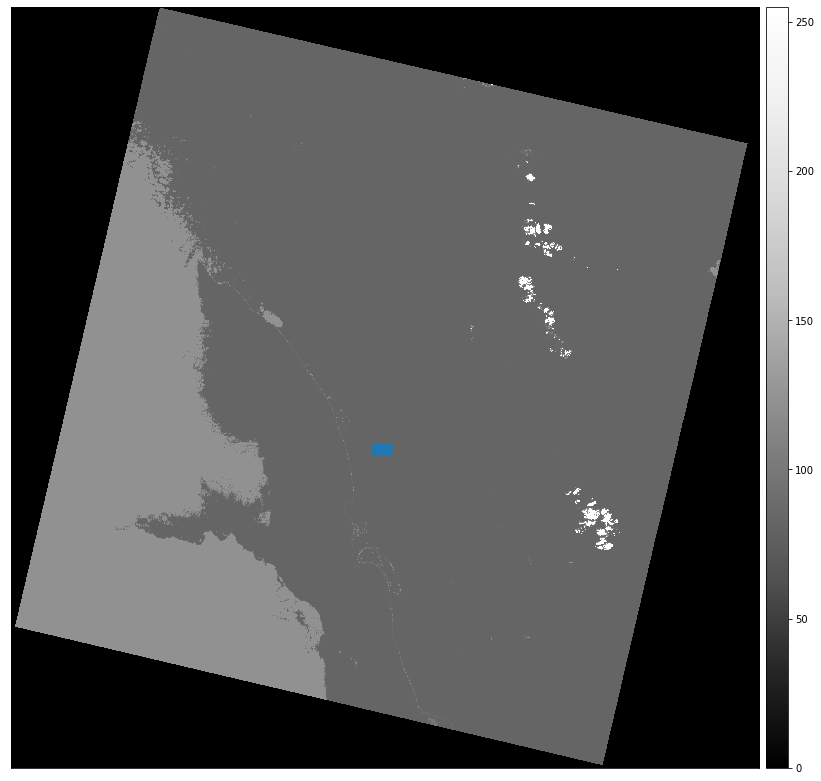

In [14]:
fig, ax, = plt.subplots()
ep.plot_bands(bernardo_csf[0], ax= ax, extent = extent)
bernardo_boundary.plot(ax= ax)
# tomahawk-boundary.plot(ax=ax2)

In [15]:
# # YOUR CODE HERE
# # Define list of directories in "sites"
# all_sites = glob(os.path.join(base_path, "*/"))
# all_sites.sort()
# all_sites

# # Create an empty lists to store site name, date, and mean ndvi
# composite_list = []
# cleaned_landsat_ndvi = {}
# # cleaned_landsat_nbr = {}

# # Define the directory name, it is an explicit directory.
# landsat_dir = "landsat-crop"

# # Loop through each site directory
# # first loop to go to harv and sjer direcotry
# for site_dir in all_sites:
    
#     # Get site name
#     site = os.path.basename(os.path.normpath(site_dir)) 
# #     print(site_dir)
# #     print(site)
# #     print(date)
    
#     # Define a dynamic boundary path for the site
#     boundary_path = os.path.join(site_dir, "vector", 
#                                  site + "_box.shp")

# #     print(boundary_path)
#     fire_boundary = gpd.read_file(boundary_path)
# #     print(fire_boundary)
   
#     # Get a list of subdirectories for that site
#     new_path = os.path.join(site_dir, landsat_dir)
# #     print("new path:", new_path)
    
#     # all dirs is acessing all image directory
#     # inner loop iterates on each of these (23)x2 subdirectories.
#     all_dirs = glob(new_path + "/*/")  
#     all_dirs.sort()
# #     print("all directories:", all_dirs)

#     # Loop through each subdirectory for site
#     # the second loop opens tif files
#     for dir in all_dirs:
#         date = os.path.basename(os.path.normpath(dir))[-8:] 
# #         print(date)
        
#         # Get all bands in each subdirectory for site
#         site_bands = glob(dir + "*.tif")
#         site_bands.sort()
#         print(site_bands)
# #         with rio.open(site_bands[1]) as src:
# #         fire_boundary_prj= fire_boundary.to_crs(bernardo_src.crs)
#         # create plotting extent
#         with rio.open(site_bands[3]) as src:
#             extent = plotting_extent(src)
#             fire_boundary_prj= fire_boundary.to_crs(src.crs)
# #             print(src.crs)
#         # Run function to calculate NDVI for that subdirectory (scene)
#             ndvi_clean = open_band_ndvi(bands= 
#                             site_bands, site_bounds= fire_boundary_prj)
# #         print(ndvi_clean.mean())
#             composite_list.append([site, ndvi_clean, date])
#         # add cleaned ndvi_clean to the dictionary
#             cleaned_landsat_ndvi[date] = {site: ndvi_clean}

# print(cleaned_landsat_ndvi)


In [16]:
# Create loop to process Landsat data in this cell
# Setting path to scene directories
# Define list of directories in "sites" 
## all_sites is replaced with all_dirs
all_sites = glob(os.path.join(base_path, "*/"))
all_sites.sort()
# all_sites
# print(all_sites)

# data_path = os.path.join("earthpy-downloads",
#                          "landsat-coldsprings-hw")
# all_dirs = glob(os.path.join(data_path, "L*/"))
# print(all_dirs)

#### Create empty dictionary
# cleaned_landsat_data = {}
##* Create an empty lists to store site name, date, and mean ndvi
composite_list = []
cleaned_landsat_data = {}
cleaned_landsat_nbr = {}

# ##* Define the directory name, it is an explicit directory.
landsat_dir = "landsat-crop"
# Loop through each site directory
# first loop to go to site direcotry
for site_dir in all_sites:
    
    # Get site name
    site = os.path.basename(os.path.normpath(site_dir)) 
#     print(site_dir)
    print("Dyanmic sites:", site)
#     print(date)
    
    # Define a dynamic boundary path for the site
    # "_box" is replaced with the '2014.shp'
    boundary_path = os.path.join(site_dir, "vector", 
                                 site + "_box.shp")

    print("Dyanmic boundary path:", boundary_path)
    fire_boundary = gpd.read_file(boundary_path)
#     print("Dyanmic fire boundary:", fire_boundary)
   
    # Get a list of subdirectories for that site
    new_path = os.path.join(site_dir, landsat_dir)
#     print("new path:", new_path)
    # Loop through each subdirectory for site
    # the second loop opens tif files
    #####  dir is replaced by scenes
    ##### all_dir is replaced with site dir
        # inner loop iterates on each of these (23)x2 subdirectories.
    all_dirs = glob(new_path + "/*/")  
    all_dirs.sort()
    print(all_dirs)
    for scenes in all_dirs:
        date = os.path.basename(os.path.normpath(scenes))[-8:]
#         print(all_dirs)
        print(date)
        


#         # Get all tif files in landsat_dir, the directory
        all_scenes = sorted(glob(os.path.join(scenes, "*.tif")))
        crop_path = os.path.join(scenes, "cropped")
        if not os.path.exists(crop_path):
            os.mkdir(crop_path)
#         print(crop_path)


        # crop & stack data
        stacked_bands, stacked_bands_meta, fire_crop_bound = crop_stack_data(
                                     files_to_crop=all_scenes,
                                     crop_dir_path=crop_path,
                                     crop_bound=fire_boundary)

        # Paths to cropped qa and bands
        cropped_qa = glob(os.path.join(crop_path,
                                   "*pixel**crop*.tif"))
        cropped_scenes = sorted(glob(os.path.join(crop_path,
                                              "*band*")))

        # Mask all landsat scenes of bad pixels and remove nodata
        bands_arr, bands_meta = es.stack(cropped_scenes, nodata=1.0)
        saved_array = mask_data(bands_arr, cropped_qa)
        cleaned_landsat_data[site+"_"+ date] = {"stacked_array": saved_array}
#         print(saved_array)
        
        # create plotting extent
        with rio.open(cropped_scenes[3]) as landsat_src:
            extent = plotting_extent(landsat_src)
#         cleaned_landsat_nbr[site] = {date: saved_array}

# # print("plotting extent:", extent)
# # print("fire cropped boundary CRS:", fire_crop_bound.crs)
print(cleaned_landsat_data)

Dyanmic sites: BERNARDO
Dyanmic boundary path: data\sd_fires_2014\sites\BERNARDO\vector\BERNARDO_box.shp
['data\\sd_fires_2014\\sites\\BERNARDO\\landsat-crop\\Landsat20140407\\', 'data\\sd_fires_2014\\sites\\BERNARDO\\landsat-crop\\landsat20140509\\', 'data\\sd_fires_2014\\sites\\BERNARDO\\landsat-crop\\landsat20140525\\']
20140407
There are no pixels to mask
20140509
20140525
There are no pixels to mask
Dyanmic sites: COCOS
Dyanmic boundary path: data\sd_fires_2014\sites\COCOS\vector\COCOS_box.shp
['data\\sd_fires_2014\\sites\\COCOS\\landsat-crop\\landsat20140509\\', 'data\\sd_fires_2014\\sites\\COCOS\\landsat-crop\\landsat20140525\\']
20140509
20140525
There are no pixels to mask
Dyanmic sites: POINSETTIA
Dyanmic boundary path: data\sd_fires_2014\sites\POINSETTIA\vector\POINSETTIA_box.shp
['data\\sd_fires_2014\\sites\\POINSETTIA\\landsat-crop\\landsat20140509\\', 'data\\sd_fires_2014\\sites\\POINSETTIA\\landsat-crop\\landsat20140525\\']
20140509
There are no pixels to mask
20140525
D

In [17]:
print(cleaned_landsat_data.keys())

dict_keys(['BERNARDO_20140407', 'BERNARDO_20140509', 'BERNARDO_20140525', 'COCOS_20140509', 'COCOS_20140525', 'POINSETTIA_20140509', 'POINSETTIA_20140525', 'PULGAS_20140509', 'PULGAS_20140525', 'TOMAHAWK_20140509', 'TOMAHAWK_20140525'])


In [18]:

# cleaned_landsat_data["BERNARDO"].keys()#['BERNARDO']

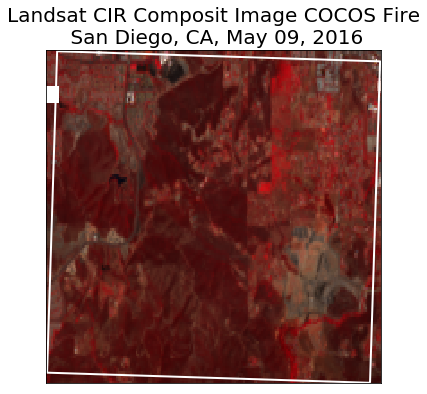

In [19]:
fig, ax = plt.subplots(1, 1, figsize=(6, 10))
offset=-.03
# Plot Landsat CIR
ep.plot_rgb(cleaned_landsat_data["COCOS_20140509"]["stacked_array"],
            rgb=[4, 3, 2],
            extent=extent,
            ax=ax,
            title="Landsat CIR Composit Image COCOS Fire"
            "\n San Diego, CA, May 09, 2016")
fire_crop_bound.plot(ax=ax, color="None",
                     edgecolor="white", linewidth=2)

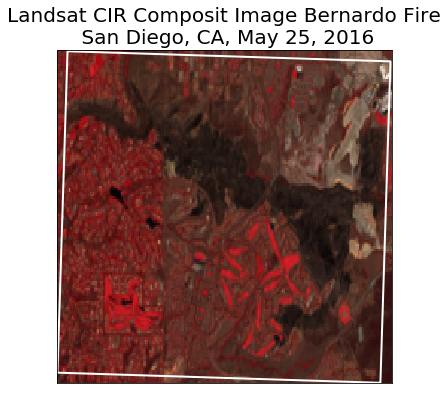

In [20]:
fig, ax = plt.subplots(1, 1, figsize=(6, 10))
offset=-.03
# Plot Landsat CIR
ep.plot_rgb(cleaned_landsat_data["BERNARDO_20140525"]["stacked_array"],
            rgb=[4, 3, 2],
            extent=extent,
            ax=ax,
            title="Landsat CIR Composit Image Bernardo Fire"
            "\n San Diego, CA, May 25, 2016")
fire_crop_bound.plot(ax=ax, color="None",
                     edgecolor="white", linewidth=2)

In [21]:
# Landsat NBR processing-BERNARDO
landsat_prefire_nbr_bernardo7 = es.normalized_diff(
    cleaned_landsat_data["BERNARDO_20140407"]["stacked_array"][4],
    cleaned_landsat_data["BERNARDO_20140407"]["stacked_array"][6])
landsat_postfire_nbr_bernardo25 = es.normalized_diff(
    cleaned_landsat_data["BERNARDO_20140525"]["stacked_array"][4],
    cleaned_landsat_data["BERNARDO_20140525"]["stacked_array"][6])

# Calculate landsat dnbr as pre - post fire nbr and divide into five classes
landsat_dnbr = landsat_prefire_nbr_bernardo7 - landsat_postfire_nbr_bernardo25
landsat_dnbr_reclass = classify_dnbr(landsat_dnbr)
print(landsat_dnbr_reclass)

[[1 1 1 ... 2 2 2]
 [1 1 1 ... 2 2 2]
 [1 1 2 ... 2 2 2]
 ...
 [2 2 2 ... 2 2 2]
 [2 2 2 ... 2 2 2]
 [2 2 2 ... 2 2 2]]


In [22]:
# Landsat NBR processing-BERNARDO
landsat_prefire_nbr_bernardo9 = es.normalized_diff(
    cleaned_landsat_data["BERNARDO_20140509"]["stacked_array"][4],
    cleaned_landsat_data["BERNARDO_20140509"]["stacked_array"][6])
landsat_postfire_nbr_bernardo25 = es.normalized_diff(
    cleaned_landsat_data["BERNARDO_20140525"]["stacked_array"][4],
    cleaned_landsat_data["BERNARDO_20140525"]["stacked_array"][6])

# Calculate landsat dnbr as pre - post fire nbr and divide into five classes
landsat_dnbr = landsat_prefire_nbr_bernardo9 - landsat_postfire_nbr_bernardo25
landsat_dnbr_reclass = classify_dnbr(landsat_dnbr)
print(landsat_dnbr_reclass)

[[2 2 2 ... 2 2 2]
 [2 2 2 ... 2 2 2]
 [2 2 2 ... 2 2 2]
 ...
 [2 2 2 ... 2 2 2]
 [2 2 2 ... 2 2 2]
 [2 2 2 ... 2 2 2]]


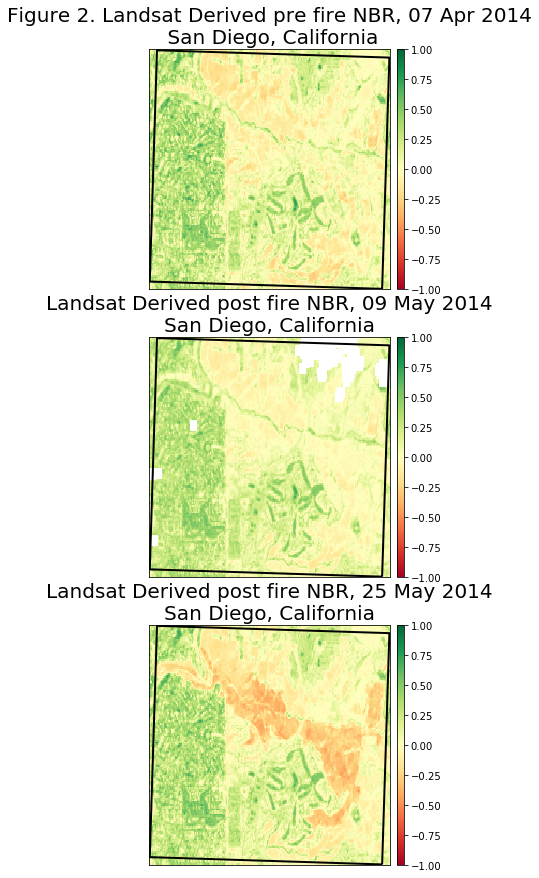

In [23]:
# Define color pallets_BERNARDO
colors = ["g", "yellowgreen", "peachpuff", "coral", "maroon"]
class_labels = ["Enhanced Regrowth", "Unburned", "Low Severity",
                "Moderate Severity", "High Severity"]

cmap = ListedColormap(colors)

# Plot pre, post NBR
fig, [ax1, ax2,ax3] = plt.subplots(3, 1,
                                         figsize=(10, 15))
# Landsat pre and post fire NBR
ep.plot_bands(landsat_prefire_nbr_bernardo7, cmap="RdYlGn",
              vmin=-1, vmax=1, ax=ax1,
              extent=extent,
              scale=False,
              title="Figure 2. Landsat Derived pre fire NBR, 07 Apr 2014\n " +
                    "San Diego, California")
fire_crop_bound.plot(ax=ax1, color='None', edgecolor='black', linewidth=2)
ep.plot_bands(landsat_prefire_nbr_bernardo9, cmap="RdYlGn",
              vmin=-1, vmax=1, ax=ax2,
              extent=extent,
              scale=False,
              title="Landsat Derived post fire NBR, 09 May 2014\n" +
                    "San Diego, California")
fire_crop_bound.plot(ax=ax2, color='None', edgecolor='black', linewidth=2)
ep.plot_bands(landsat_postfire_nbr_bernardo25, cmap="RdYlGn",
              vmin=-1, vmax=1, ax=ax3,
              extent=extent,
              scale=False,
              title="Landsat Derived post fire NBR, 25 May 2014\n" +
                    "San Diego, California")
fire_crop_bound.plot(ax=ax3, color='None', edgecolor='black', linewidth=2)


In [24]:
# Landsat NBR processing-TOMAHAWK
landsat_prefire_nbr = es.normalized_diff(
    cleaned_landsat_data["TOMAHAWK_20140509"]["stacked_array"][4],
    cleaned_landsat_data["TOMAHAWK_20140509"]["stacked_array"][6])
landsat_postfire_nbr = es.normalized_diff(
    cleaned_landsat_data["TOMAHAWK_20140525"]["stacked_array"][4],
    cleaned_landsat_data["TOMAHAWK_20140509"]["stacked_array"][6])

# Calculate landsat dnbr as pre - post fire nbr and divide into five classes
landsat_dnbr = landsat_prefire_nbr - landsat_postfire_nbr
landsat_dnbr_reclass = classify_dnbr(landsat_dnbr)
print(landsat_dnbr_reclass)

[[2 2 2 ... 2 2 2]
 [2 2 2 ... 2 2 2]
 [2 2 2 ... 2 2 2]
 ...
 [2 2 2 ... 2 2 2]
 [3 3 2 ... 2 2 2]
 [4 3 3 ... 2 2 2]]


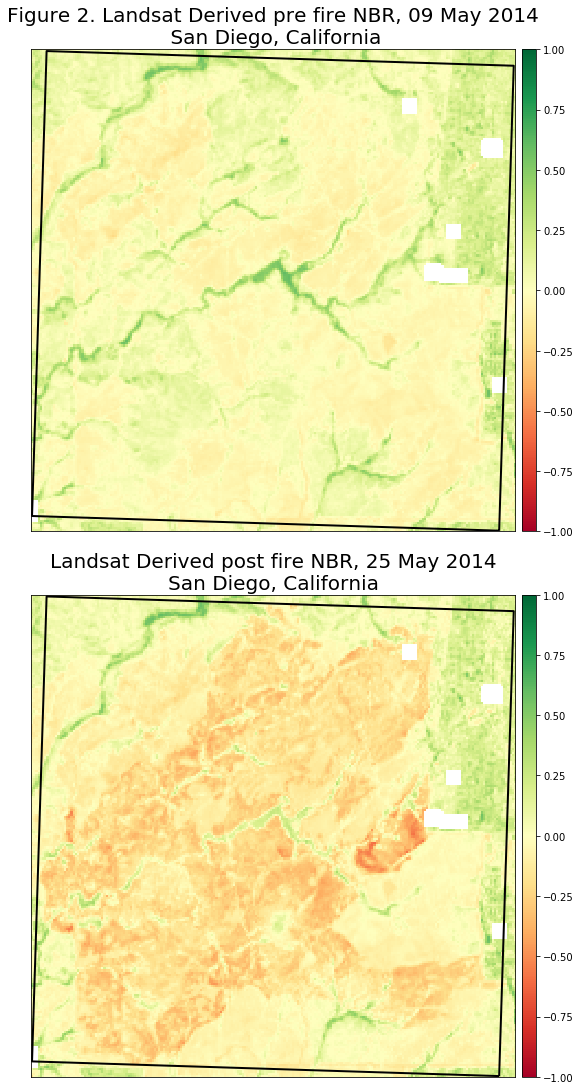

In [25]:
# Define color pallets
colors = ["g", "yellowgreen", "peachpuff", "coral", "maroon"]
class_labels = ["Enhanced Regrowth", "Unburned", "Low Severity",
                "Moderate Severity", "High Severity"]

cmap = ListedColormap(colors)

# Plot pre, post NBR
fig, [ax1, ax2] = plt.subplots(2, 1,
                                         figsize=(10, 15), constrained_layout=True)
# Landsat pre and post fire NBR
ep.plot_bands(landsat_prefire_nbr, cmap="RdYlGn",
              vmin=-1, vmax=1, ax=ax1,
              extent=extent,
              scale=False,
              title="Figure 2. Landsat Derived pre fire NBR, 09 May 2014\n " +
                    "San Diego, California")
fire_crop_bound.plot(ax=ax1, color='None', edgecolor='black', linewidth=2)
ep.plot_bands(landsat_postfire_nbr, cmap="RdYlGn",
              vmin=-1, vmax=1, ax=ax2,
              extent=extent,
              scale=False,
              title="Landsat Derived post fire NBR, 25 May 2014\n" +
                    "San Diego, California")
fire_crop_bound.plot(ax=ax2, color='None', edgecolor='black', linewidth=2)


In [26]:
# Pre and postfire and the difference between two NDVI_TOMAHAWK
landsat_prefire_ndvi = es.normalized_diff(
    cleaned_landsat_data["TOMAHAWK_20140509"]["stacked_array"][4],
    cleaned_landsat_data["TOMAHAWK_20140509"]["stacked_array"][3])
landsat_postfire_ndvi = es.normalized_diff(
    cleaned_landsat_data["TOMAHAWK_20140525"]["stacked_array"][4],
    cleaned_landsat_data["TOMAHAWK_20140525"]["stacked_array"][3])
landsat_dndvi_tomahawk = landsat_postfire_ndvi - landsat_prefire_ndvi
print(landsat_dndvi_tomahawk)

[[-0.08404356872166274 0.0034337686846014903 -0.0459888168281235 ...
  -0.017667738248555276 0.012924200713823664 0.006927271311806371]
 [-0.07402311048818494 0.05971202710333151 -0.04843256996035744 ...
  -0.07070518186081579 0.01962528632965005 -0.03935913572477451]
 [-0.03728109152974213 -0.010217791635365181 -0.0003128116302119621 ...
  0.0015170649997093832 -0.0025264796810609003 0.03291735685275371]
 ...
 [0.07043689959205157 0.0549935225849455 0.0714726909166376 ...
  0.00436583945498048 0.052128435595080236 -0.008589054852328137]
 [0.0731557192413389 0.05488373125703691 0.10323734797480516 ...
  0.02114187748516111 0.020617267408102158 -0.0036553208780378266]
 [-0.023664427532051863 0.11090329373063423 0.1509661282336992 ...
  0.03941625289125894 -0.030699521720206346 -0.005897116563833904]]


In [27]:
# Pre and postfire and the difference between two NDVI_TOMAHAWK
landsat_prefire_ndvi = es.normalized_diff(
    cleaned_landsat_data["BERNARDO_20140509"]["stacked_array"][4],
    cleaned_landsat_data["BERNARDO_20140509"]["stacked_array"][3])
landsat_postfire_ndvi = es.normalized_diff(
    cleaned_landsat_data["BERNARDO_20140525"]["stacked_array"][4],
    cleaned_landsat_data["BERNARDO_20140525"]["stacked_array"][3])
landsat_dndvi_bernardo = landsat_postfire_ndvi - landsat_prefire_ndvi
print(landsat_dndvi_bernardo)

[[0.005566979574363973 -0.004391947768610571 0.029877999252725107 ...
  0.0679006772109248 0.024692684512428092 0.0016547815357908502]
 [-0.003774280287290488 -0.027258897526345027 0.010046658322520441 ...
  0.011852318631712655 -0.015085908529048175 -0.024494655385416092]
 [-0.028516655101832045 -0.027891664327512333 0.007471688786816477 ...
  0.01349656697290802 0.06664284175035506 0.0036219277601218236]
 ...
 [-0.05986287430144299 -0.10038599846449292 -0.005130753226233187 ...
  -0.002147087723869845 -0.005887091850842796 -0.009239922739267437]
 [-0.020137932095823152 -0.05522539072321306 0.025702932022199754 ...
  -0.015144992423198778 -0.006963662172350893 -0.027773401869029657]
 [-0.039166679869293064 -0.033645933469276634 0.018109581422541765 ...
  -0.01433150311324033 -0.022679434376982444 -0.030326747912549246]]


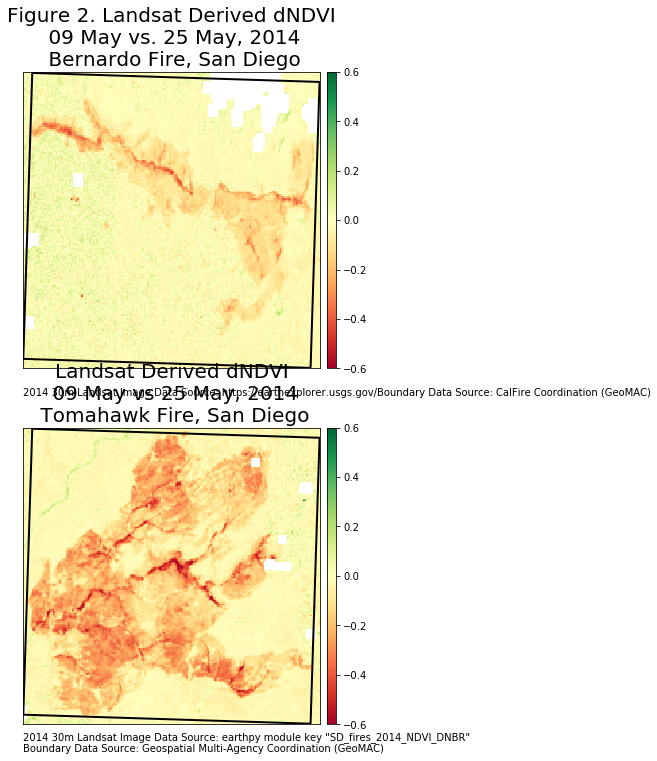

In [28]:
# Plot Difference NDVI for Landsat BERNARDO AND TOMAHAWK together in one figure
fig, [ax1, ax2] = plt.subplots(2, 1, figsize=(12, 12))

# Plot Landsat dNDVI
ep.plot_bands(landsat_dndvi_bernardo, cmap="RdYlGn",
              vmin=-0.6, vmax=0.6, ax = ax1, extent=extent,
              title="Figure 2. Landsat Derived dNDVI\n 09 May vs. 25 May," \
                    " 2014\n Bernardo Fire, San Diego", scale=False)

fire_crop_bound.plot(ax=ax1, color='None', 
                      edgecolor='black', linewidth=2)

# Plot modis dNDVI
ep.plot_bands(landsat_dndvi_tomahawk, cmap="RdYlGn",
              vmin=-0.6, vmax=0.6, ax = ax2, extent=extent,
              title="Landsat Derived dNDVI\n 09 May vs 25 May," \
                    " 2014\n Tomahawk Fire, San Diego", scale=False)

fire_crop_bound.plot(ax=ax2, color='None', 
                    edgecolor='black', linewidth=2)

# Figure captions
ax1.text(0, -0.1, '2014 30m Landsat Image Data Source: ' \
         'https://earthexplorer.usgs.gov/' 
         r'Boundary Data Source: CalFire ' \
         r'Coordination (GeoMAC)', verticalalignment='bottom',  
         horizontalalignment='left', transform=ax1.transAxes)

ax2.text(0, -0.1, '2014 30m Landsat Image Data Source: earthpy ' \
         'module key "SD_fires_2014_NDVI_DNBR" \n'
         r'Boundary Data Source: Geospatial Multi-Agency ' \
         r'Coordination (GeoMAC)', verticalalignment='bottom',  
         horizontalalignment='left', transform=ax2.transAxes)

### DO NOT REMOVE LINE BELOW ###
plot02_landsat_modis_ndvi_diff = nb.convert_axes(plt, which_axes="all")

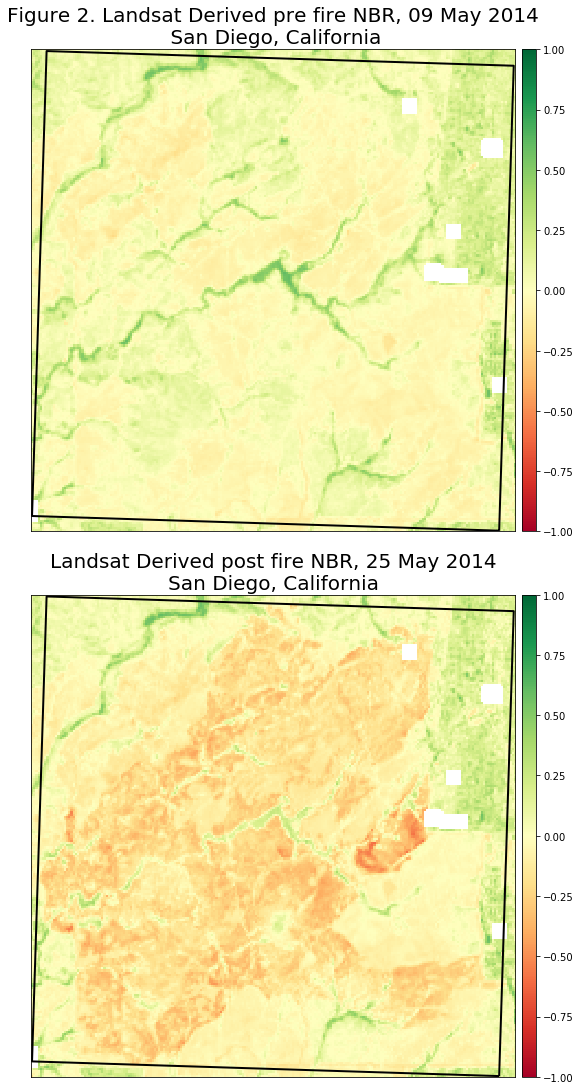

In [29]:
# Define color pallets
colors = ["g", "yellowgreen", "peachpuff", "coral", "maroon"]
class_labels = ["Enhanced Regrowth", "Unburned", "Low Severity",
                "Moderate Severity", "High Severity"]

cmap = ListedColormap(colors)

# Plot pre, post NBR
fig, [ax1, ax2] = plt.subplots(2, 1,
                                         figsize=(10, 15), constrained_layout=True)
# Landsat pre and post fire NBR
ep.plot_bands(landsat_prefire_nbr, cmap="RdYlGn",
              vmin=-1, vmax=1, ax=ax1,
              extent=extent,
              scale=False,
              title="Figure 2. Landsat Derived pre fire NBR, 09 May 2014\n " +
                    "San Diego, California")
fire_crop_bound.plot(ax=ax1, color='None', edgecolor='black', linewidth=2)
ep.plot_bands(landsat_postfire_nbr, cmap="RdYlGn",
              vmin=-1, vmax=1, ax=ax2,
              extent=extent,
              scale=False,
              title="Landsat Derived post fire NBR, 25 May 2014\n" +
                    "San Diego, California")
fire_crop_bound.plot(ax=ax2, color='None', edgecolor='black', linewidth=2)
